In [1]:
%%capture
%run ch04_linear_algebra.ipynb
%run ch05_statistics.ipynb
%run ch06_probability.ipynb
%run ch08_gradient_descent.ipynb

In [2]:
# 1-D data

from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket size"""
    
    return bucket_size * math.floor(point / bucket_size) # first value of the n-th bucket

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts haw many in each bucket"""
    
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [3]:
import random

random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean  0, standard deviation 57
normal = [57 * inverse_normal_cdf(random.random()) for _ in range(10000)]

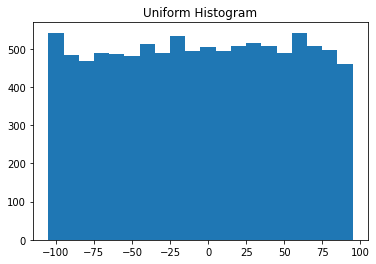

In [4]:
plot_histogram(uniform, 10, "Uniform Histogram")

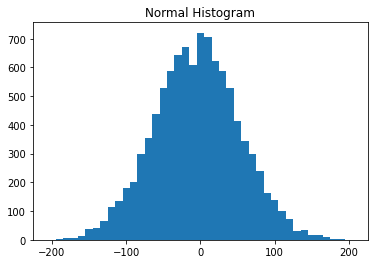

In [5]:
plot_histogram(normal, 10, "Normal Histogram")

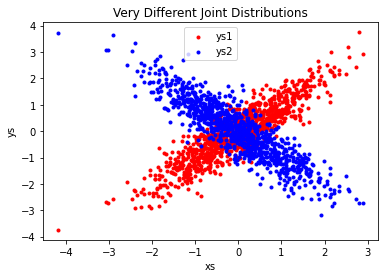

In [6]:
# 2-D data

def random_normal() -> float:
    """Returns a random draw from a standard normal distribution"""
    
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)] # 1000 data points
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

plt.scatter(xs, ys1, marker='.', color='red', label='ys1')
plt.scatter(xs, ys2, marker='.', color='blue', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

In [7]:
print(correlation(xs, ys1)) # positive correlation
print(correlation(xs, ys2)) # negative correlation

0.9010493686379609
-0.8920981526880033


In [8]:
# N-D data

def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Returns the len(data) x len(data) matrix whose (i, j)-th entry
    is the correlation between data[i] and data[j]
    """
    
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])
        
    return make_matrix(len(data), len(data), correlation_ij)

vectors = [xs, ys1, ys2]
correlation_matrix(vectors)
# assert correlation_matrix(vectors) == [
#     [correlation(xs,  xs), correlation(xs,  ys1), correlation(xs,  ys2)],
#     [correlation(ys1, xs), correlation(ys1, ys1), correlation(ys1, ys2)],
#     [correlation(ys2, xs), correlation(ys2, ys1), correlation(ys2, ys2)],
# ]

[[1.0, 0.9010493686379609, -0.8920981526880033],
 [0.9010493686379609, 1.0, -0.8072731481569311],
 [-0.8920981526880033, -0.8072731481569311, 1.0]]

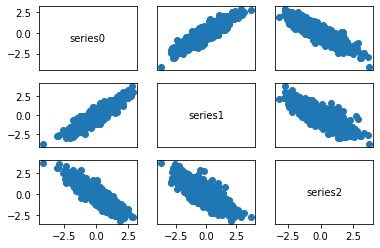

In [9]:
# Scatterplot matrix

num_vectors = len(vectors)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):
        
        # Scatter column_j on the x-axis vs. column_i on the y-axis
        if i != j:
            ax[i][j].scatter(vectors[j], vectors[i])
        
        # unless i == j, in which case show the series name
        else:
            ax[i][j].annotate("series" + str(i), (0.5, 0.5), 
                              xycoords='axes fraction', 
                              ha="center", 
                              va="center")
        
        # then hide axis labels except left and bottom charts
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)
            
# Fix the bottom-right and top-left axis lables, 
# which are wrong because their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

In [10]:
# NamedTuples (immutable)
# Dataclasses (mutable) is available for Python > 3.7

from collections import namedtuple
import datetime

StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2020, 11, 25), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03

In [11]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float
        
    def is_high_tech(self) -> bool:
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']
    
price = StockPrice('MSFT', datetime.date(2020, 11, 25), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

In [12]:
# Data clearning and munging (type transformation)

from typing import Optional
from dateutil.parser import parse
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row
    
    # Stock symbol should be all captial letters
    if not re.match(r"^[A-Z]+$", symbol):
        return None
    
    try:
        date = parse(date_).date()
    except ValueError:
        return None
    
    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None
    
    return StockPrice(symbol, date, closing_price)

assert try_parse_row(["MSFT0", "2020-11-25", "106.03"]) is None
assert try_parse_row(["MSFT", "2020-11--25", "106.03"]) is None
assert try_parse_row(["MSFT", "2020-11-25", "x"]) is None

In [13]:
import csv

data: List[StockPrice] = []
    
with open("data/stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"skipping invalid row: {row}")
        else:
            data.append(maybe_stock)
            
data

skipping invalid row: ['MSFT', '6/19/2014', 'n/a']


[StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 20), closing_price=90.91),
 StockPrice(symbol='MSFT', date=datetime.date(2014, 6, 20), closing_price=41.68),
 StockPrice(symbol='FB', date=datetime.date(3014, 6, 20), closing_price=64.5),
 StockPrice(symbol='AAPL', date=datetime.date(2014, 6, 19), closing_price=91.86),
 StockPrice(symbol='FB', date=datetime.date(2014, 6, 19), closing_price=64.34)]

In [14]:
# Manipulating data

from dateutil.parser import parse
import csv

with open("data/stocks.csv", "r") as f:
    reader = csv.DictReader(f)
    rows = [[row['Symbol'], row['Date'], row['Close']]
            for row in reader]

# skip header
maybe_data = [try_parse_row(row) for row in rows]

# Make sure they all loaded successfully:
assert maybe_data
assert all(sp is not None for sp in maybe_data)

# This is just to make mypy happy
data = [sp for sp in maybe_data if sp is not None]

print(len(data))

23105


In [15]:
# Max price for AAPL

max_aapl_price = max(stock_price.closing_price 
                     for stock_price in data 
                     if stock_price.symbol == "AAPL")

print(max_aapl_price)

232.070007


In [16]:
# Max prices for all stocks

from collections import defaultdict

max_prices: Dict[str, float] = defaultdict(lambda: float('-inf'))
    
for sp in data:
    symbol, closing_price = sp.symbol, sp.closing_price
    if closing_price > max_prices[symbol]:
        max_prices[symbol] = closing_price
        
print(max_prices)
print(max_prices['GOOG'])

defaultdict(<function <lambda> at 0x0000015420231D08>, {'AAPL': 232.070007, 'MSFT': 115.610001, 'FB': 217.5, 'GOOG': 1268.329956})
1268.329956


In [17]:
# Largest and smallest one-day percent changes

from typing import List
from collections import defaultdict

# Collect the prices by symbol
prices: Dict[str, List[StockPrice]] = defaultdict(list)
    
for sp in data:
    prices[sp.symbol].append(sp)
    
# Order the prices by date
prices = {symbol: sorted(symbol_prices) 
          for symbol, symbol_prices 
          in prices.items()}

def pct_change(yesterday: StockPrice, today: StockPrice) -> float:
    return (today.closing_price / yesterday.closing_price) - 1

class DailyChange(NamedTuple):
    symbol: str
    date: datetime.date
    pct_change: float

def day_over_day_changes(prices: List[StockPrice]) -> List[DailyChange]:
    """
    Assume prices are for one stock and in order
    """
    return [DailyChange(symbol=today.symbol, 
                        date=today.date, 
                        pct_change=pct_change(yesterday, today)) 
            for yesterday, today in zip(prices, prices[1:])]

all_changes = [change 
               for symbol_prices in prices.values() 
               for change in day_over_day_changes(symbol_prices)]

In [18]:
max_change = max(all_changes, key=lambda change: change.pct_change)
assert max_change.symbol == 'AAPL'
assert max_change.date == datetime.date(1997, 8, 6)
assert 0.33 < max_change.pct_change < 0.34

min_change = min(all_changes, key=lambda change: change.pct_change)
assert min_change.symbol == 'AAPL'
assert min_change.date == datetime.date(2000, 9, 29)
assert -0.52 < min_change.pct_change < -0.51

In [19]:
# Month of the largest percent changes

changes_by_month: List[DailyChange] = {month: [] for month in range(1, 13)}
    
for change in all_changes:
    changes_by_month[change.date.month].append(change)

avg_daily_change = {
    month: sum(change.pct_change for change in changes) / len(changes)
    for month, changes in changes_by_month.items()
}

assert avg_daily_change[10] == max(avg_daily_change.values())

In [20]:
# Scaling

from typing import Tuple

def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """Returns the mean and standard deviation for each position"""
    
    dim = len(data[0])
    
    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data]) 
              for i in range(dim)]
    
    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)
assert means == [-1, 0, 1]
assert stdevs == [2, 1, 0]

In [21]:
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Rescales the input data so that each position has mean 0 and standard deviation 1.
    Leaves a position as is if its standard deviation is 0.
    """
    
    dim = len(data[0])
    means, stdevs = scale(data)
    
    # Makes a copy of each vector
#     rescaled = [v[:] for v in data]
    rescaled = data
    
    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
                
    return rescaled

means, stdevs = scale(rescale(vectors))
assert means == [0, 0, 1] # 3rd element ogiginally has zero standard deviation
assert stdevs == [1, 1, 0] 

In [22]:
# tqdm

import tqdm

for i in tqdm.tqdm(range(100)):
    _ = [random.random() for _ in range(1000000)] # do something slow

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.67it/s]


In [23]:
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]
    
    with tqdm.trange(3, n) as t:
        for i in t:
            # i is prime if no smaller prime divides it
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)
                
            t.set_description(f"{len(primes)} primes")
            
    return primes

my_primes = primes_up_to(1000)

168 primes: 100%|██████████████████████████████████████████████████████████████████| 997/997 [00:00<00:00, 1301.65it/s]


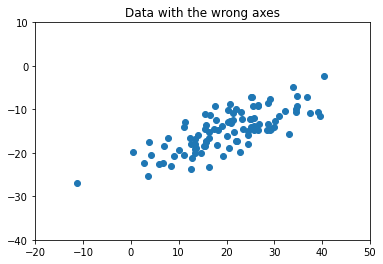

In [24]:
# Dimensionality reduction

pca_data = [
[20.9666776351559,-13.1138080189357],
[22.7719907680008,-19.8890894944696],
[25.6687103160153,-11.9956004517219],
[18.0019794950564,-18.1989191165133],
[21.3967402102156,-10.8893126308196],
[0.443696899177716,-19.7221132386308],
[29.9198322142127,-14.0958668502427],
[19.0805843080126,-13.7888747608312],
[16.4685063521314,-11.2612927034291],
[21.4597664701884,-12.4740034586705],
[3.87655283720532,-17.575162461771],
[34.5713920556787,-10.705185165378],
[13.3732115747722,-16.7270274494424],
[20.7281704141919,-8.81165591556553],
[24.839851437942,-12.1240962157419],
[20.3019544741252,-12.8725060780898],
[21.9021426929599,-17.3225432396452],
[23.2285885715486,-12.2676568419045],
[28.5749111681851,-13.2616470619453],
[29.2957424128701,-14.6299928678996],
[15.2495527798625,-18.4649714274207],
[26.5567257400476,-9.19794350561966],
[30.1934232346361,-12.6272709845971],
[36.8267446011057,-7.25409849336718],
[32.157416823084,-10.4729534347553],
[5.85964365291694,-22.6573731626132],
[25.7426190674693,-14.8055803854566],
[16.237602636139,-16.5920595763719],
[14.7408608850568,-20.0537715298403],
[6.85907008242544,-18.3965586884781],
[26.5918329233128,-8.92664811750842],
[-11.2216019958228,-27.0519081982856],
[8.93593745011035,-20.8261235122575],
[24.4481258671796,-18.0324012215159],
[2.82048515404903,-22.4208457598703],
[30.8803004755948,-11.455358009593],
[15.4586738236098,-11.1242825084309],
[28.5332537090494,-14.7898744423126],
[40.4830293441052,-2.41946428697183],
[15.7563759125684,-13.5771266003795],
[19.3635588851727,-20.6224770470434],
[13.4212840786467,-19.0238227375766],
[7.77570680426702,-16.6385739839089],
[21.4865983854408,-15.290799330002],
[12.6392705930724,-23.6433305964301],
[12.4746151388128,-17.9720169566614],
[23.4572410437998,-14.602080545086],
[13.6878189833565,-18.9687408182414],
[15.4077465943441,-14.5352487124086],
[20.3356581548895,-10.0883159703702],
[20.7093833689359,-12.6939091236766],
[11.1032293684441,-14.1383848928755],
[17.5048321498308,-9.2338593361801],
[16.3303688220188,-15.1054735529158],
[26.6929062710726,-13.306030567991],
[34.4985678099711,-9.86199941278607],
[39.1374291499406,-10.5621430853401],
[21.9088956482146,-9.95198845621849],
[22.2367457578087,-17.2200123442707],
[10.0032784145577,-19.3557700653426],
[14.045833906665,-15.871937521131],
[15.5640911917607,-18.3396956121887],
[24.4771926581586,-14.8715313479137],
[26.533415556629,-14.693883922494],
[12.8722580202544,-21.2750596021509],
[24.4768291376862,-15.9592080959207],
[18.2230748567433,-14.6541444069985],
[4.1902148367447,-20.6144032528762],
[12.4332594022086,-16.6079789231489],
[20.5483758651873,-18.8512560786321],
[17.8180560451358,-12.5451990696752],
[11.0071081078049,-20.3938092335862],
[8.30560561422449,-22.9503944138682],
[33.9857852657284,-4.8371294974382],
[17.4376502239652,-14.5095976075022],
[29.0379635148943,-14.8461553663227],
[29.1344666599319,-7.70862921632672],
[32.9730697624544,-15.5839178785654],
[13.4211493998212,-20.150199857584],
[11.380538260355,-12.8619410359766],
[28.672631499186,-8.51866271785711],
[16.4296061111902,-23.3326051279759],
[25.7168371582585,-13.8899296143829],
[13.3185154732595,-17.8959160024249],
[3.60832478605376,-25.4023343597712],
[39.5445949652652,-11.466377647931],
[25.1693484426101,-12.2752652925707],
[25.2884257196471,-7.06710309184533],
[6.77665715793125,-22.3947299635571],
[20.1844223778907,-16.0427471125407],
[25.5506805272535,-9.33856532270204],
[25.1495682602477,-7.17350567090738],
[15.6978431006492,-17.5979197162642],
[37.42780451491,-10.843637288504],
[22.974620174842,-10.6171162611686],
[34.6327117468934,-9.26182440487384],
[34.7042513789061,-6.9630753351114],
[15.6563953929008,-17.2196961218915],
[25.2049825789225,-14.1592086208169]
]

xs = [vector[0] for vector in pca_data]
ys = [vector[1] for vector in pca_data]

import matplotlib.pyplot as plt

plt.scatter(xs, ys)
plt.title("Data with the wrong axes")
plt.xlim(-20, 50)
plt.ylim(-40, 10)
plt.show()

In [25]:
def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""
    
    mean = vector_mean(data)
    
    return [subtract(vector, mean) for vector in data]

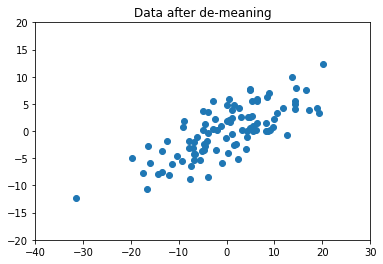

In [26]:
de_meaned_pca_data = de_mean(pca_data)

xs = [vector[0] for vector in de_meaned_pca_data]
ys = [vector[1] for vector in de_meaned_pca_data]

plt.scatter(xs, ys)
plt.title("Data after de-meaning")
plt.xlim(-40, 30)
plt.ylim(-20, 20)
plt.show()

In [27]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    
    return [w_i / mag for w_i in w] # direction vector

In [28]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """
    Returns the variance of x in the direction of w
    """
    
    w_dir = direction(w)
    
    return sum(dot(v, w_dir) ** 2 for v in data)

In [29]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
    The gradient of directional variance with respect to w
    """
    
    w_dir = direction(w)
    
    return [sum(2 * dot(v, w_dir) * v[i] for v in data) 
            for i in range(len(w))]

In [30]:
def first_principal_component(data: List[Vector], 
                              n: int = 100, 
                              step_size: float = 0.1) -> Vector:
    
    # start with a random guess (initial direction vector)
    guess = [1.0 for _ in data[0]]
    
    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")
            
    return direction(guess)

first_principal_component(de_meaned_pca_data)

dv: 10279.151: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 802.15it/s]


[0.9237307801943212, 0.3830423549969252]

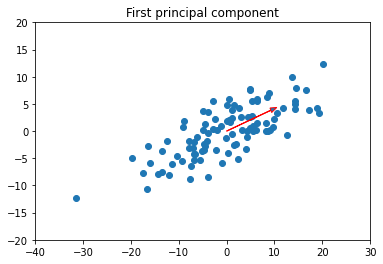

In [31]:
xs = [vector[0] for vector in de_meaned_pca_data]
ys = [vector[1] for vector in de_meaned_pca_data]

plt.scatter(xs, ys)
plt.title("First principal component")
plt.xlim(-40, 30)
plt.ylim(-20, 20)
plt.arrow(0, 0, 9.24, 3.83, head_width=0.9, width=0.05, ec='red')
plt.show() 

In [32]:
def project(v: Vector, w: Vector) -> Vector:
    """Returns the projection of v onto the direction w"""
    
    projection_length = dot(v, w)
    
    return scalar_multiply(projection_length, w)

def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """Projects v onto w and subtracts the result from v"""
    
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data] 

dv: 10279.151: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 777.27it/s]


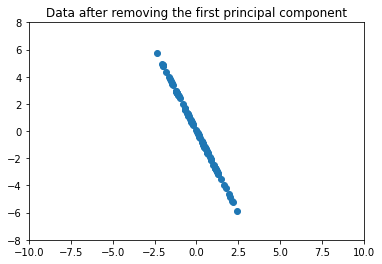

In [33]:
fpc_removed_pca_data = remove_projection(de_meaned_pca_data, first_principal_component(de_meaned_pca_data))

xs = [vector[0] for vector in fpc_removed_pca_data]
ys = [vector[1] for vector in fpc_removed_pca_data]

plt.scatter(xs, ys)
plt.title("Data after removing the first principal component")
plt.xlim(-10, 10)
plt.ylim(-8, 8)
plt.show()

In [34]:
# PCA

def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
        
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)
        
    return components

In [35]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

In [36]:
pca(de_meaned_pca_data, 2)

dv: 821.030: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 765.40it/s]


[[0.9237307801943212, 0.3830423549969252],
 [-0.3829683874572463, 0.9237614487563316]]

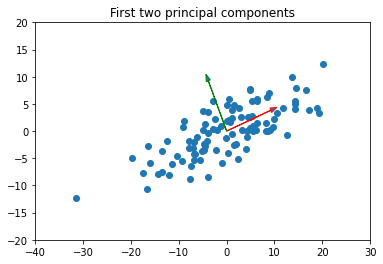

In [37]:
xs = [vector[0] for vector in de_meaned_pca_data]
ys = [vector[1] for vector in de_meaned_pca_data]

plt.scatter(xs, ys)
plt.title("First two principal components")
plt.xlim(-40, 30)
plt.ylim(-20, 20)
plt.arrow(0, 0, 9.24, 3.83, head_width=0.9, width=0.05, ec='red')
plt.arrow(0, 0, -3.83, 9.24, head_width=0.9, width=0.05, ec='green')
plt.show() 